In [1]:
# MLB Attendance Data - DATA 301 Final Project

In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import bs4
import time
import json
import math

In [141]:
team_names = {"ARI": ["ARI"],
              "ATL": ["ATL", "MLN", "BSN"], 
              "BAL": ["BAL", "SLB", "MLA"], 
              "BOS": ["BOS"], 
              "CHC": ["CHC"], 
              "CHW": ["CHW"], 
              "CIN": ["CIN"], 
              "CLE": ["CLE"], 
              "COL": ["COL"], 
              "DET": ["DET"], 
              "HOU": ["HOU"], 
              "KCR": ["KCR"], 
              "LAA": ["LAA", "ANA", "CAL"], 
              "LAD": ["LAD", "BRO"], 
              "MIA": ["MIA", "FLA"], 
              "MIL": ["MIL", "SEP"],
              "MIN": ["MIN", "WSH"], 
              "NYM": ["NYM"],
              "NYY": ["NYY"],
              "OAK": ["OAK", "KCA", "PHA"],
              "PHI": ["PHI"],
              "PIT": ["PIT"],
              "SDP": ["SDP"],
              "SFG": ["SFG", "NYG"], 
              "SEA": ["SEA"], 
              "STL": ["STL"], 
              "TBD": ["TBD", "TBR"],
              "TEX": ["TEX", "WSA"], 
              "TOR": ["TOR"],
              "WSN": ["WSN", "MON"]
              }

teams = dict.fromkeys(team_names)
reverse_lookup = dict( (v, k) for k in team_names for v in team_names[k] )

mlb = {
    "American": {
        "East": ["BAL", "BOS", "NYY", "TOR", "TBD"], 
        "Central": ["CHW", "CLE", "DET", "KCR", "MIN"], 
        "West": ["HOU", "LAA", "OAK", "SEA", "TEX"],
    },
    "National": {
        "East": ["ATL", "MIA", "NYM", "PHI", "WSN"], 
        "Central": ["CIN", "CHC", "MIL", "PIT", "STL"], 
        "West": ["ARI", "COL", "LAD", "SDP", "SFG"],
    },
}

div = {
          "ARI": "NW",
          "ATL": "NE", 
          "BAL": "AE", 
          "BOS": "AE", 
          "CHC": "NC", 
          "CHW": "AC", 
          "CIN": "NC", 
          "CLE": "AC", 
          "COL": "NW", 
          "DET": "AC", 
          "HOU": "AW", 
          "KCR": "AC", 
          "LAA": "AW", 
          "LAD": "NW", 
          "MIA": "NE", 
          "MIL": "NC",
          "MIN": "AC", 
          "NYM": "NE",
          "NYY": "AE",
          "OAK": "AW",
          "PHI": "NE",
          "PIT": "NC",
          "SDP": "NW",
          "SFG": "NW", 
          "SEA": "AW", 
          "STL": "NC", 
          "TBD": "AE",
          "TEX": "AW", 
          "TOR": "AE",
          "WSN": "NE",
        }

In [ ]:
for key in team_names.keys():
    games = []
    print(key)
    for year in range(2000,2016):
        for team in team_names[key]:
            url = "http://www.baseball-reference.com/teams/" + team + "/" + str(year) + "-schedule-scores.shtml"
            page = requests.get(url)
            season = BeautifulSoup(page.text, "html.parser")

            table = season.find("div", {"id": "div_team_schedule"},class_="table_container")
            if table is not None:
                table = table.find_all("tr", class_="")
                for row in table[1:-1]:
                    if "thead" not in row["class"]:
                        values = row.find_all("td")
                        games.append({
                                "Date": values[2].text.split()[2] + " " + values[2].text.split(" ")[1] + " " + str(year),
                                "Year": year,
                                "DOW" : values[2].text.split(" ")[0][0:-1],
                                "Month" : values[2].text.split(" ")[1],
                                "Opp" : values[6].text,
                                "W/L" : values[7].text[0],
                                "Game" : values[1].text,
                                "WO" : "Y" if len(values[7].text) > 1 else "N",
                                "GB" : 0 if "Tied" in values[13].text 
                                        else (values[13].text).replace(" ", "").replace("up", "-"),
                                "Time" : values[18].text,
                                "Attendance" : values[19].text.replace(",", ""),
                                "Streak" : len(values[20].text),
                                "Home" : values[5].text,
                                "Pct" : 0 if (float(values[11].text.split("-")[0]) + float(values[11].text.split("-")[1])) == 0 
                                            else float(values[11].text.split("-")[0]) / (float(values[11].text.split("-")[0]) + float(values[11].text.split("-")[1])),
                                "RS" : int(values[8].text),
                                "RA" : int(values[9].text),
                                "Pitcher" : (values[14].find("a")["title"] if values[14].find("a") is not None else "") 
                                            if values[7].text[0] == "W" else (values[15].find("a")["title"] if values[15].find("a") is not None else ""),
                                "OPitcher" : (values[15].find("a")["title"] if values[15].find("a") is not None else "") 
                                            if values[7].text[0] == "W" else (values[14].find("a")["title"] if values[14].find("a") is not None else ""),
                                "Team" : team,
                            })
                break

            time.sleep(0.1)
    d = pd.DataFrame(games)
    if "Attendance" in d:
        d["Attendance"] = pd.to_numeric(d["Attendance"])
    teams[team] = d

### REFRESH DATA:

In [142]:
# LOAD JSON FILES TO NOTEBOOK
for team in teams.keys():
    with open(team + '.json', 'r') as f:
        try:
            teams[team] = pd.read_json( json.load(f) )
        # if the file is empty the ValueError will be thrown
        except ValueError:
            teams[team] = {}

In [143]:
# CLEANING UP THE MESS THAT IS THE TAMPA BAY RAYS
if "TBR" in teams:
    teams["TBD"] = teams["TBR"] 
    del teams["TBR"]

In [93]:
# FOR SAVING JSON FILES
# for team in teams.keys():
#     with open(team + '.json', 'w') as f:
#             json.dump(teams[team].to_json(), f)

In [132]:
# for team in teams.keys():
#     teams[team]["RSZ"] = teams[team]["RS"].rolling(center=False, window=162, min_periods=1).sum()
#     teams[team]["RAZ"] = teams[team]["RA"].rolling(center=False, window=162, min_periods=1).sum()     
    

In [144]:
away = teams.copy()

for team in teams.keys():
    temp = teams[team]
    temp_away = away[team]
    
    temp["OVERALL_GAME"] = pd.to_numeric(temp.reset_index()["index"]) + 1
    temp["Date"] = pd.to_datetime(temp["Date"], format='%d %b %Y')
    temp["Year-DT"] = temp["Year"].apply(str) 
    temp["Year-DT"] = pd.to_datetime( temp["Year-DT"], format='%Y' )
    temp_away = temp[temp["Home"] == "@"]
    temp = temp[temp["Home"] != "@"]
    temp.fillna(0)
    temp_away.fillna(0)
    away[team] = temp_away
    teams[team] = temp


In [145]:
ALL = pd.DataFrame()
ALL_AWAY = pd.DataFrame()

for team in teams.keys():
    ALL = pd.concat([ALL, teams[team]], axis=0)
    ALL_AWAY = pd.concat([ALL_AWAY, away[team]], axis=0)

In [146]:
for abbrev in reverse_lookup.keys():
    ALL = ALL.replace(abbrev, reverse_lookup[abbrev])
    ALL_AWAY = ALL_AWAY.replace(abbrev, reverse_lookup[abbrev])
    for team in teams.keys():
        teams[team] = teams[team].replace(abbrev, reverse_lookup[abbrev])
        away[team] = away[team].replace(abbrev, reverse_lookup[abbrev])

In [147]:
ALL_MERGE = pd.merge(ALL, ALL_AWAY, left_on=["Date", "Team", "Time"], right_on=["Date", "Opp", "Time"])
ALL_MERGE = ALL_MERGE[["Attendance_x", "Team_x", "Opp_x", "DOW_x", "GB_x", "GB_y", "Opp_x", "Month_x", "Pitcher_x", 
        "OPitcher_x", "Pct_x", "Pct_y", "RA_x", "RS_x", "Streak_x", "Streak_y", "W/L_x", "DOW_x", "WO_x", 
        "Game_x", "Time", "Date", "Year_x"]]

In [161]:
# def same_divison (r):
#     print(r["Team"])
#     a = div[r["Team"]]
#     b = div[r["Opp_x"]]
#     if a == b:
#         return 1
#     else:
#         return 0

# ALL_MERGE["Intra"] = ALL_MERGE.apply(same_divison)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

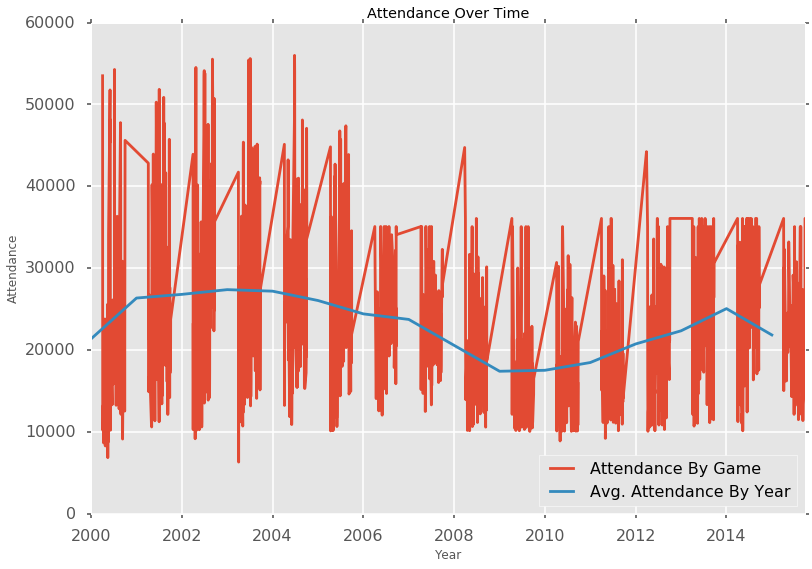

In [10]:
# ATTENDANCE OVER TIME (GROUPED BY MONTHLY AVERAGE)

att_time_game = teams["OAK"][teams["OAK"]["Home"] != "@"].sort_values("Date")
plt.style.use("seaborn-poster")
plt.style.use("ggplot")
plt.plot(att_time_game["Date"], att_time_game["Attendance"])

att_time_year = att_time_game.groupby("Year-DT").mean()["Attendance"].to_frame().reset_index()

plt.plot(att_time_year["Year-DT"], att_time_year["Attendance"])
plt.ylabel("Attendance")
plt.xlabel("Year")
plt.title("Attendance Over Time")
plt.legend(["Attendance By Game", "Avg. Attendance By Year"], loc=4)

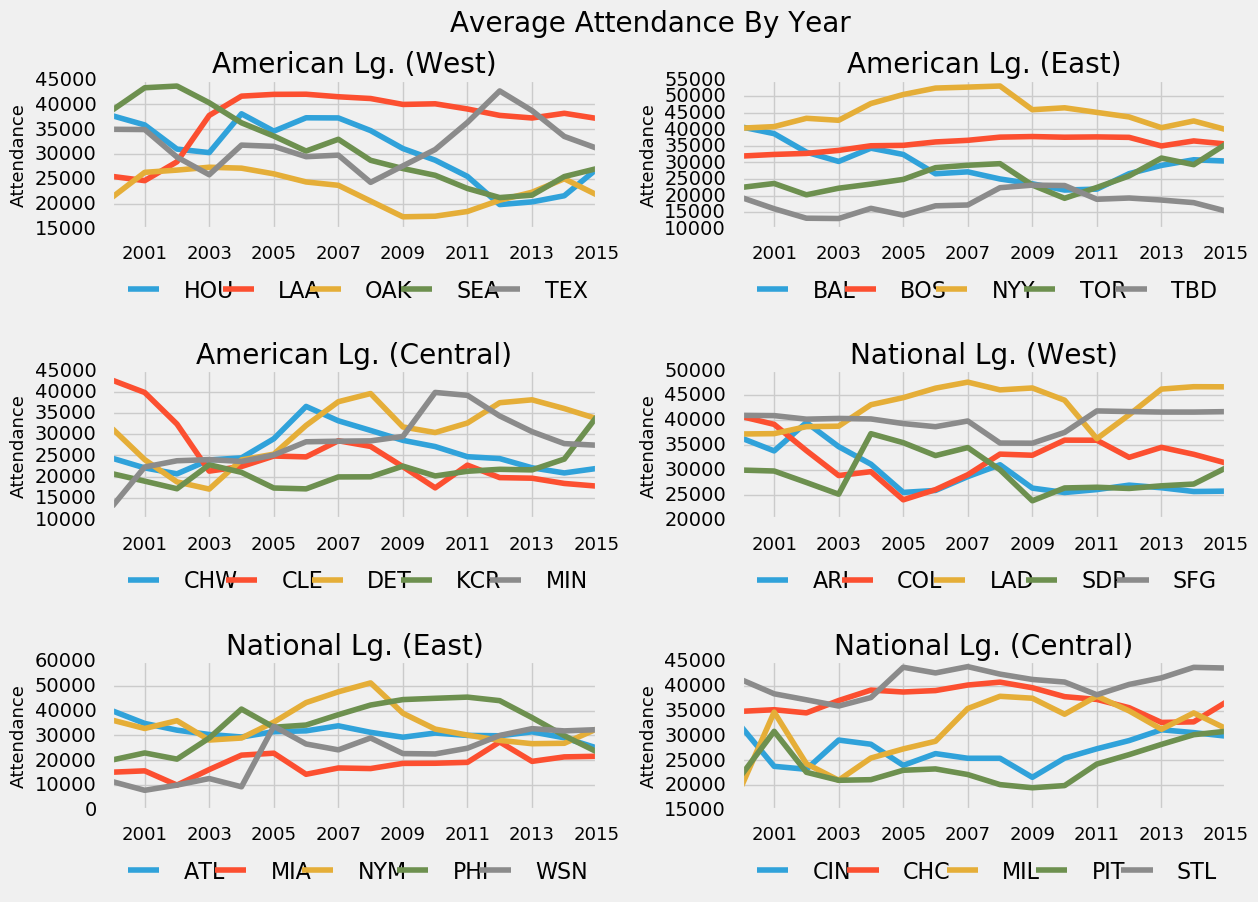

In [11]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use("seaborn-poster")
plt.style.use("fivethirtyeight")
plt.rc("ytick", labelsize= 14)
plt.rc("xtick", labelsize= 13)
i = 0
for league in mlb:
    for division in mlb[league]:
        plt.subplot(3, 2, i+1)
        for team in mlb[league][division]:
            att_time_game = teams[team].sort_values("Date")
            att_time_year = att_time_game.groupby("Year-DT").mean()["Attendance"].to_frame().reset_index()
            plt.plot(att_time_year["Year-DT"], att_time_year["Attendance"])

        plt.ylabel("Attendance", fontsize=13)
        plt.title(league + " Lg. (" + division + ")")
        plt.legend(mlb[league][division], bbox_to_anchor=(0.,-.55, 1.,-.55), loc=4, mode="expand", borderaxespad=0., ncol=5)
        i+=1 
plt.suptitle("Average Attendance By Year", fontsize=20)
plt.subplots_adjust(wspace=.3, hspace=.95)
# plt.subplots(figsize=(300, 100))

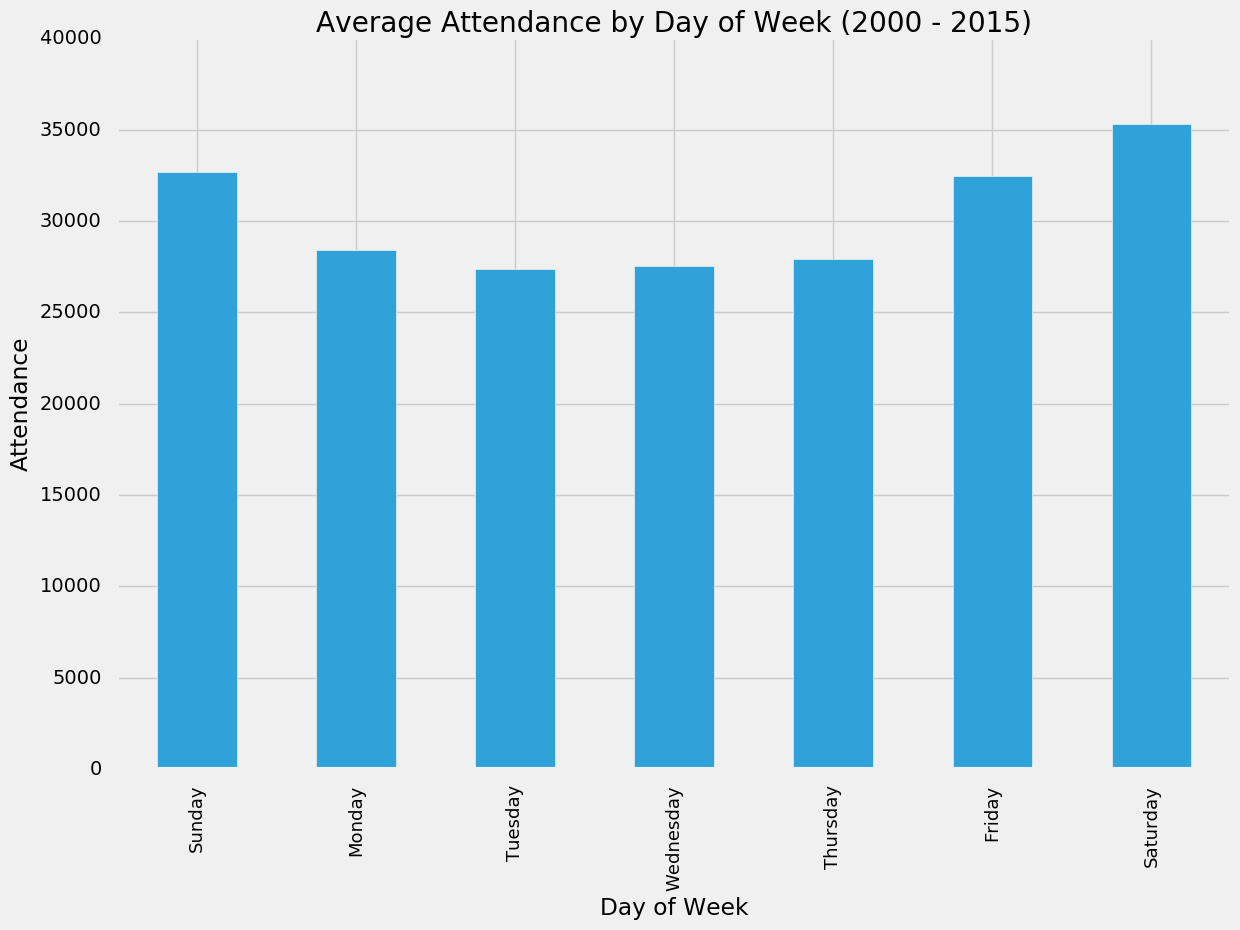

In [12]:
days = ALL.groupby("DOW").mean().reset_index()
    
weekdays = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
mapping = {day: i for i, day in enumerate(weekdays)}
key = days["DOW"].map(mapping)
days = days.iloc[key.argsort()]
      
days.set_index("DOW")["Attendance"].plot.bar()
plt.title("Average Attendance by Day of Week (2000 - 2015)")
plt.ylabel("Attendance")
plt.xlabel("Day of Week")

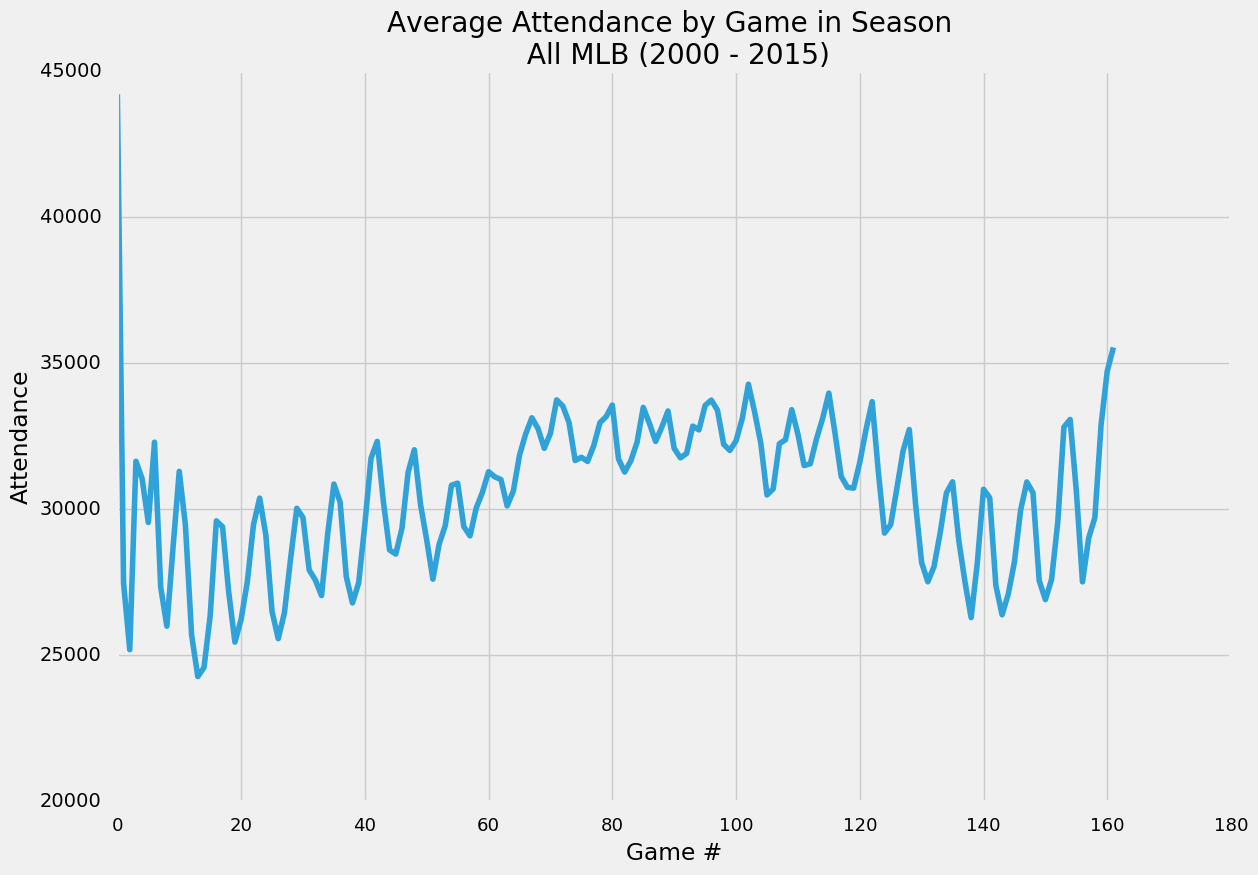

In [13]:
ALL["Game"] = pd.to_numeric(ALL["Game"], errors="coerce")

by_game = ALL.groupby("Game").mean().reset_index()[0:-1]

plt.plot(by_game["Attendance"])
plt.title("Average Attendance by Game in Season \n All MLB (2000 - 2015)")
plt.xlabel("Game #")
plt.ylabel("Attendance")

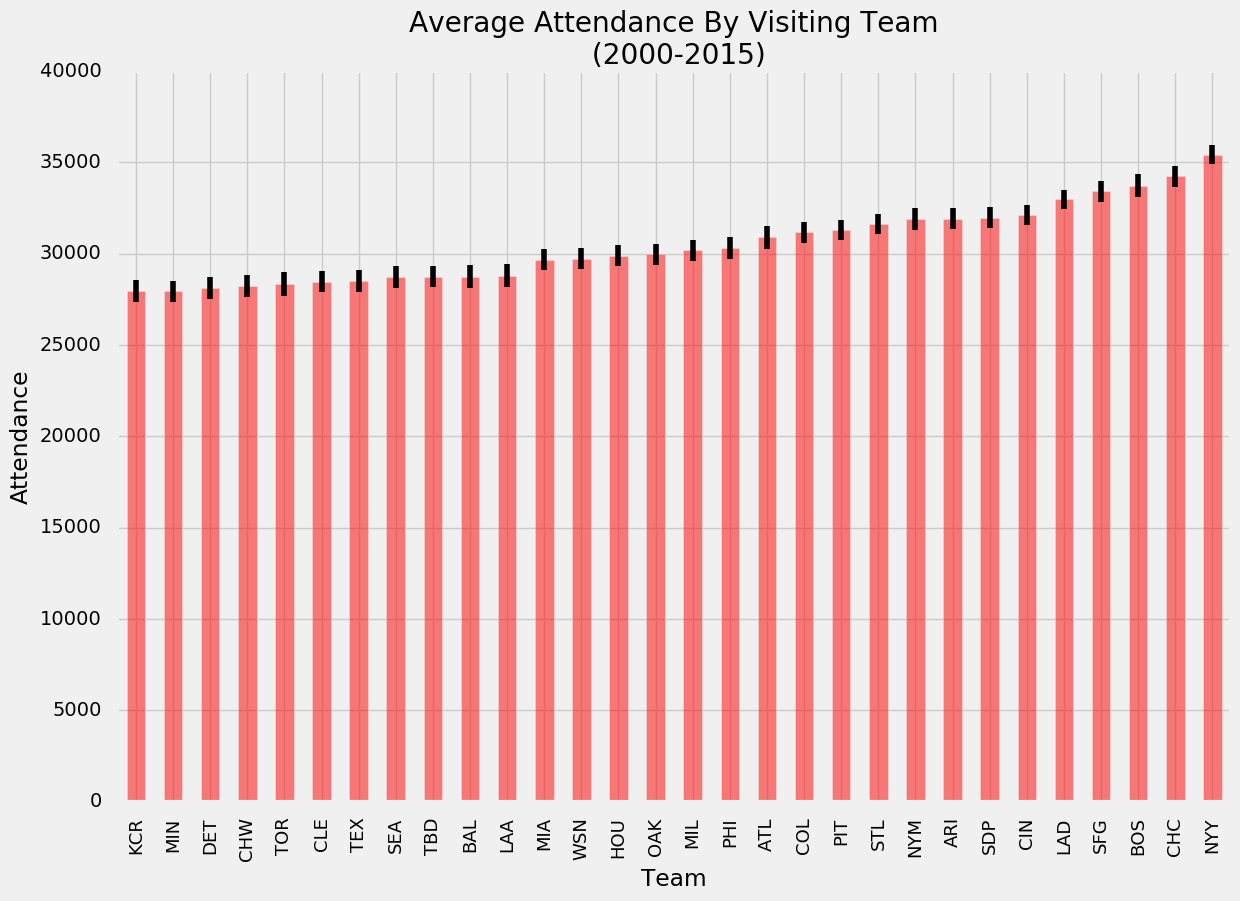

In [14]:
sort = ALL.groupby(["Opp"])["Attendance"]

error = 1.96 * (sort.std() / (sort.count() ** .5))
sort.mean().sort_values().plot.bar(yerr=error, alpha=.5, color='r')
plt.title("Average Attendance By Visiting Team\n (2000-2015)")
plt.xlabel("Team")
plt.ylabel("Attendance")

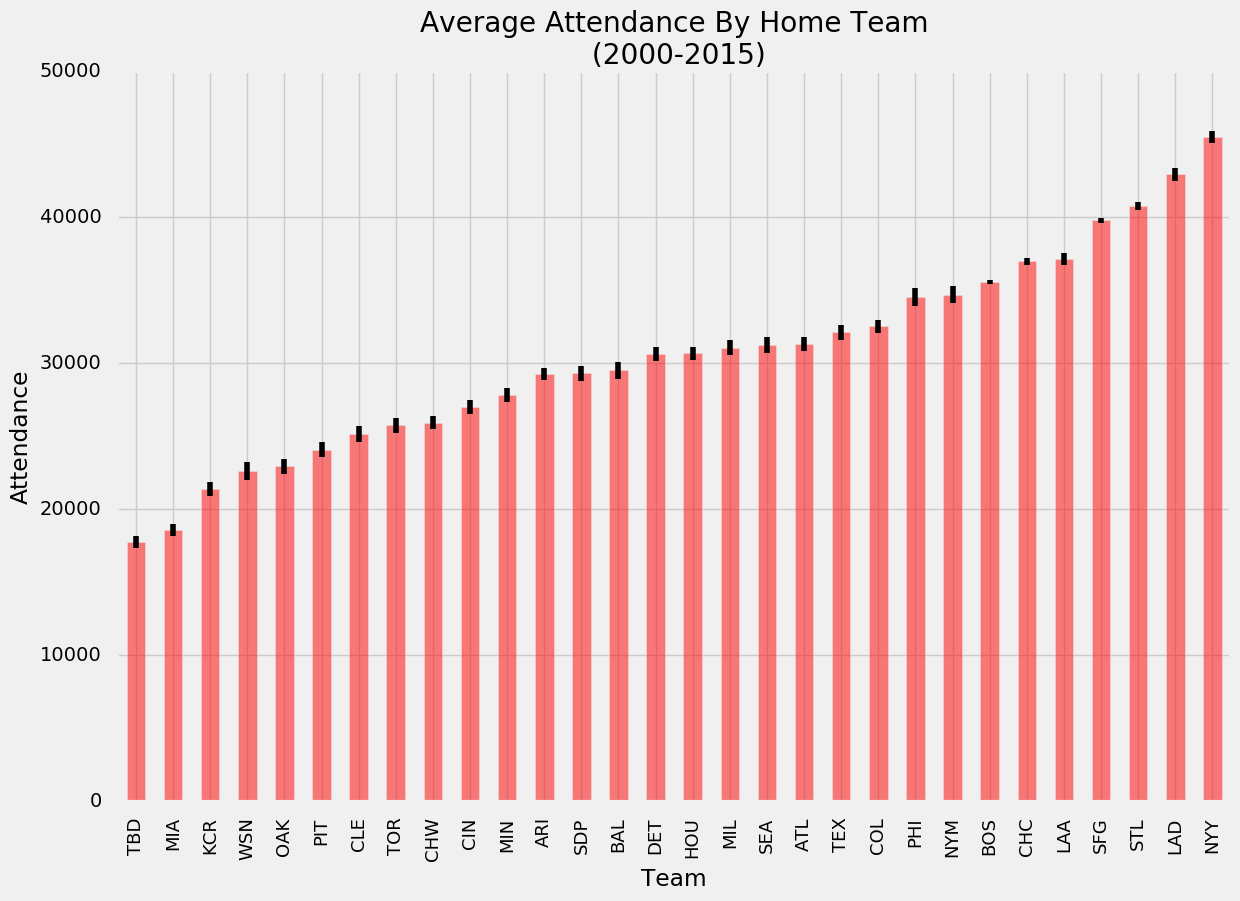

In [15]:
sort = ALL.groupby(["Team"])["Attendance"]

error = 1.96 * (sort.std() / (sort.count() ** .5))
sort.mean().sort_values().plot.bar(yerr=error, alpha=.5, color='r')
plt.title("Average Attendance By Home Team\n (2000-2015)")
plt.xlabel("Team")
plt.ylabel("Attendance")

In [27]:
matchups = {}

# getting the average attendance for every matchup
for away in teams.keys():
    matchups[away] = {}
    for home in teams.keys():
        if away != home:
            temp = teams[home]
            value = temp[temp["Opp"] == away]["Attendance"].mean()
            matchups[away][home] = 0 if math.isnan(value) else value
            
# the average home attendance for every team
home_averages = sort.mean()

effects = {}

for away in matchups.keys():
    for home in teams.keys(): #calculate the diff b/w home_averages[home] and matchups[key][home]
        if home != away:
            diff = matchups[away][home] - home_averages[home]
            if away not in effects:
                effects[away] = diff
            else:
                effects[away] += diff

In [28]:
effects = pd.Series(effects, index=teams.keys()).to_frame()
effects.columns = ["Attendance Difference"]
effects = effects.sort_values("Attendance Difference")

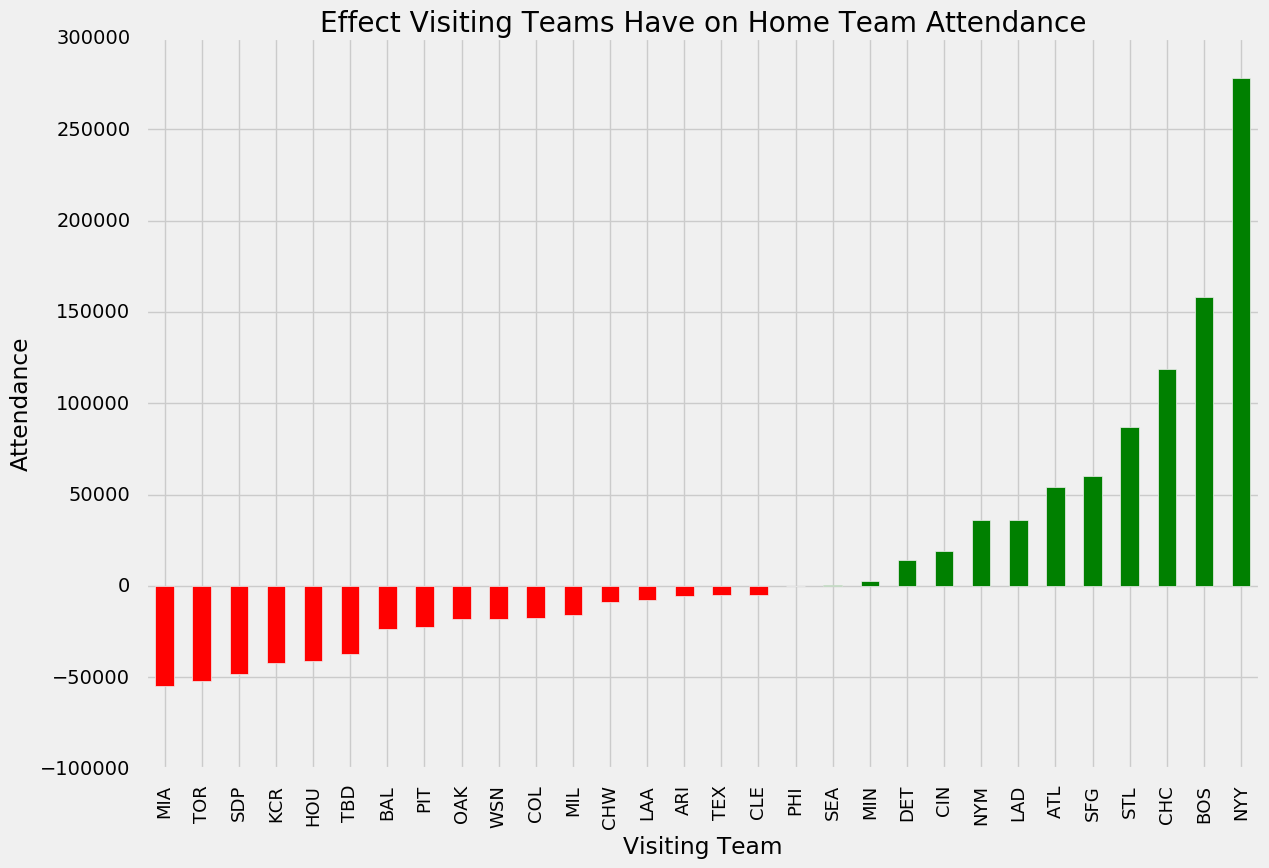

In [29]:
effects["positive"] = effects["Attendance Difference"] >= 0
effects["Attendance Difference"].plot.bar(color=effects.positive.map({True: 'green', False: "red"}))
plt.xlabel("Visiting Team")
plt.ylabel("Attendance")
plt.title("Effect Visiting Teams Have on Home Team Attendance")

In [30]:
ALL.head()

Attendance        DOW       Date   GB   Game Home Month  \
10.0       36724.0     Sunday 2000-04-16 -1.5   11.0        Apr   
100.0      32649.0    Tuesday 2000-08-01   -4  101.0        Aug   
1000.0     54769.0  Wednesday 2006-05-10    0   31.0        May   
1001.0     54956.0   Thursday 2006-05-11    1   32.0        May   
1002.0     47497.0     Friday 2006-05-12    0   33.0        May   

               OPitcher  Opp       Pct    ...     RA  RS  Streak  Team Time  \
10.0      Chris Fussell  KCR  0.727273    ...      4   8       5   NYY    D   
100.0   Ricky Bottalico  KCR  0.564356    ...      4   5       2   NYY    N   
1000.0   Curt Schilling  BOS  0.612903    ...      3   7       1   NYY    N   
1001.0    Tim Wakefield  BOS  0.593750    ...      5   3       1   NYY    N   
1002.0       Barry Zito  OAK  0.606061    ...      0   2       1   NYY    N   

       W/L WO  Year  OVERALL_GAME    Year-DT  
10.0     W  N  2000        1007.0 2000-01-01  
100.0    W  N  2000        1089.0 2000-01-01  
1000.0   W  N  2006        1900.0 2006-01-01  
1001.0   L  N  2006          20.0 2006-01-01  
1002.0   W  N  2006         191.0 2006-01-01  

[5 rows x 21 columns]